In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from scipy import stats, interpolate


TRAIN_PATH = 'flood_data/train/*.csv'
VALID_PATH = 'flood_data/valid/*.csv'
#TEST_PATH = 'flood_data/test/*.csv'
PASS = 'data/masterFileForLean_2017_2019.csv'

pd.set_option('display.max_columns', 999)


def load_csv(filepath):
    files = glob.glob(filepath)
    lis = []
    for filename in files:
        parser = lambda date: pd.to_datetime(date, format='%Y%m%d%H')
        df = pd.read_csv(filename, index_col=0, parse_dates=True, date_parser=parser,
                    usecols=[
                        0, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                        14, 15, 16, 17, 18, 20, 21, 22, 23, 24,
                        26, 27, 28, 29, 30, 32, 33, 34, 35, 36,
                        38, 39, 40, 41, 42, 44, 45, 46, 47, 48,
                        50, 51, 52, 53, 54, 56, 57, 58, 59, 60,
                        62, 63, 64, 65, 66, 68, 69, 70, 71, 72,
                        106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
                        116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                        126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
                        136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
                        146, 147, 148, 149, 150, 186
                    ])
        lis.append(df)
        df = pd.concat(lis, axis=0)
        df.index.name = 'date'
    return df

#data = load_csv(PASS)
#print(data.shape)
#data.head()

In [2]:
data = load_csv(PASS)
data.head()

,sPressMsm,sTempMsm,sHumMsm,sUgrdMsm,sVgrdMsm,sLcdcMsm,sMcdcMsm,sHcdcMsm,sTcdcMsm,hgt1000Msm,temp1000Msm,hum1000Msm,ugrd1000Msm,vgrd1000Msm,hgt975Msm,temp975Msm,hum975Msm,ugrd975Msm,vgrd975Msm,hgt950Msm,temp950Msm,hum950Msm,ugrd950Msm,vgrd950Msm,hgt925Msm,temp925Msm,hum925Msm,ugrd925Msm,vgrd925Msm,hgt900Msm,temp900Msm,hum900Msm,ugrd900Msm,vgrd900Msm,hgt850Msm,temp850Msm,hum850Msm,ugrd850Msm,vgrd850Msm,hgt800Msm,temp800Msm,hum800Msm,ugrd800Msm,vgrd800Msm,hgt700Msm,temp700Msm,hum700Msm,ugrd700Msm,vgrd700Msm,hgt600Msm,temp600Msm,hum600Msm,ugrd600Msm,vgrd600Msm,hgt500Msm,temp500Msm,hum500Msm,ugrd500Msm,vgrd500Msm,sPressGsm,sTempGsm,sHumGsm,sUgrdGsm,sVgrdGsm,sLcdcGsm,sMcdcGsm,sHcdcGsm,sTcdcGsm,hgt1000Gsm,temp1000Gsm,hum1000Gsm,ugrd1000Gsm,vgrd1000Gsm,vvel1000Gsm,hgt925Gsm,temp925Gsm,hum925Gsm,ugrd925Gsm,vgrd925Gsm,vvel925Gsm,hgt850Gsm,temp850Gsm,hum850Gsm,ugrd850Gsm,vgrd850Gsm,vvel850Gsm,hgt700Gsm,temp700Gsm,hum700Gsm,ugrd700Gsm,vgrd700Gsm,vvel700Gsm,hgt600Gsm,temp600Gsm,hum600Gsm,ugrd600Gsm,vgrd600Gsm,vvel600Gsm,hgt500Gsm,temp500Gsm,hum500Gsm,ugrd500Gsm,vgrd500Gsm,vvel500Gsm,A_temp
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 09:00:00,102796.00,283.207,59.4152,2.512950,-1.638670,2.246090,31.738300,0.0000,31.738300,227.89,280.579,60.0185,3.355850,-1.372590,435.57,278.683,59.5603,4.179160,-1.044150,647.25,277.000,53.0185,4.400010,-1.086780,863.17,275.363,51.8165,3.661070,-1.586080,1083.65,273.650,57.7108,2.762260,-2.701000,1539.23,270.011,88.0159,2.89410,-6.66722,2017.14,268.351,48.7764,8.109540,-8.91821,3062.13,266.335,5.8654,14.882100,-14.732200,4257.42,262.313,1.3772,24.354500,-17.7678,5634.39,254.183,5.4910,38.054800,-22.151600,102833.00,279.811,93.6797,0.641642,0.767023,57.128900,5.322270,0.0,57.128900,229.09,278.488,85.4047,1.717670,0.579786,0.083453,862.72,274.786,84.8704,3.28135,-3.97059,-0.023447,1538.52,270.590,72.6527,4.537880,-6.84858,0.442675,3064.54,266.624,7.4089,15.205700,-12.992800,0.705063,4259.40,262.298,2.2813,23.863400,-17.43970,0.555656,5637.20,254.288,5.9063,36.086600,-20.855200,0.336329,6.0
2017-01-01 10:00:00,102765.67,283.439,57.9528,2.928917,-1.327344,4.036457,23.600273,0.0000,23.714207,225.64,280.802,58.5770,3.521020,-1.175096,433.46,278.856,59.9649,4.017193,-0.974090,645.24,277.076,56.8311,4.036980,-1.007309,861.27,275.449,56.1568,3.247610,-1.345996,1081.82,273.740,62.9492,2.492317,-2.400120,1537.70,270.354,80.4229,3.25515,-6.14924,2016.70,269.158,39.7220,8.483713,-8.42445,3065.05,267.088,5.1055,15.350033,-13.157167,4261.66,262.458,2.4385,23.150667,-16.3193,5639.65,254.424,8.6515,36.631567,-20.021033,102792.67,280.443,89.4679,0.785278,0.550855,47.957352,4.435225,0.0,47.957352,226.30,279.079,82.2992,1.754073,0.367112,0.051626,860.70,274.980,84.7552,3.15793,-3.64174,-0.011605,1537.02,270.879,67.5135,4.979877,-6.61906,0.377764,3066.19,267.247,6.9034,15.272083,-12.535167,0.641778,4262.83,262.558,2.5677,23.717433,-16.42695,0.519735,5641.74,254.349,10.8126,35.227033,-19.271883,0.323268,6.9
2017-01-01 11:00:00,102735.33,283.670,56.4903,3.344883,-1.016017,5.826823,15.462247,0.0000,15.690113,223.38,281.026,57.1354,3.686190,-0.977603,431.34,279.030,60.3696,3.855227,-0.904030,643.23,277.153,60.6437,3.673950,-0.927837,859.36,275.535,60.4971,2.834150,-1.105912,1079.99,273.829,68.1875,2.222373,-2.099240,1536.16,270.698,72.8300,3.61620,-5.63126,2016.27,269.964,30.6676,8.857887,-7.93069,3067.98,267.840,4.3455,15.817967,-11.582133,4265.91,262.602,3.4997,21.946833,-14.8708,5644.90,254.664,11.8119,35.208333,-17.890467,102752.33,281.075,85.2561,0.928915,0.334686,38.785803,3.548180,0.0,38.785803,223.52,279.669,79.1938,1.790477,0.154437,0.019800,858.68,275.174,84.6400,3.03451,-3.31289,0.000236,1535.52,271.167,62.3744,5.421873,-6.38954,0.312853,3067.85,267.870,6.3980,15.338467,-12.077533,0.578493,4266.26,262.819,2.8542,23.571467,-15.41420,0.483815,5646.28,254.411,15.7188,34.367467,-17.688567,0.310207,9.7
2017-01-01 12:00:00,102705.00,283.902,55.0279,3.

In [3]:
print(data.shape)

(25869, 105)


In [4]:
#pd.DataFrame(data.columns).to_csv('dataset.csv')

In [5]:
from pylab import rcParams

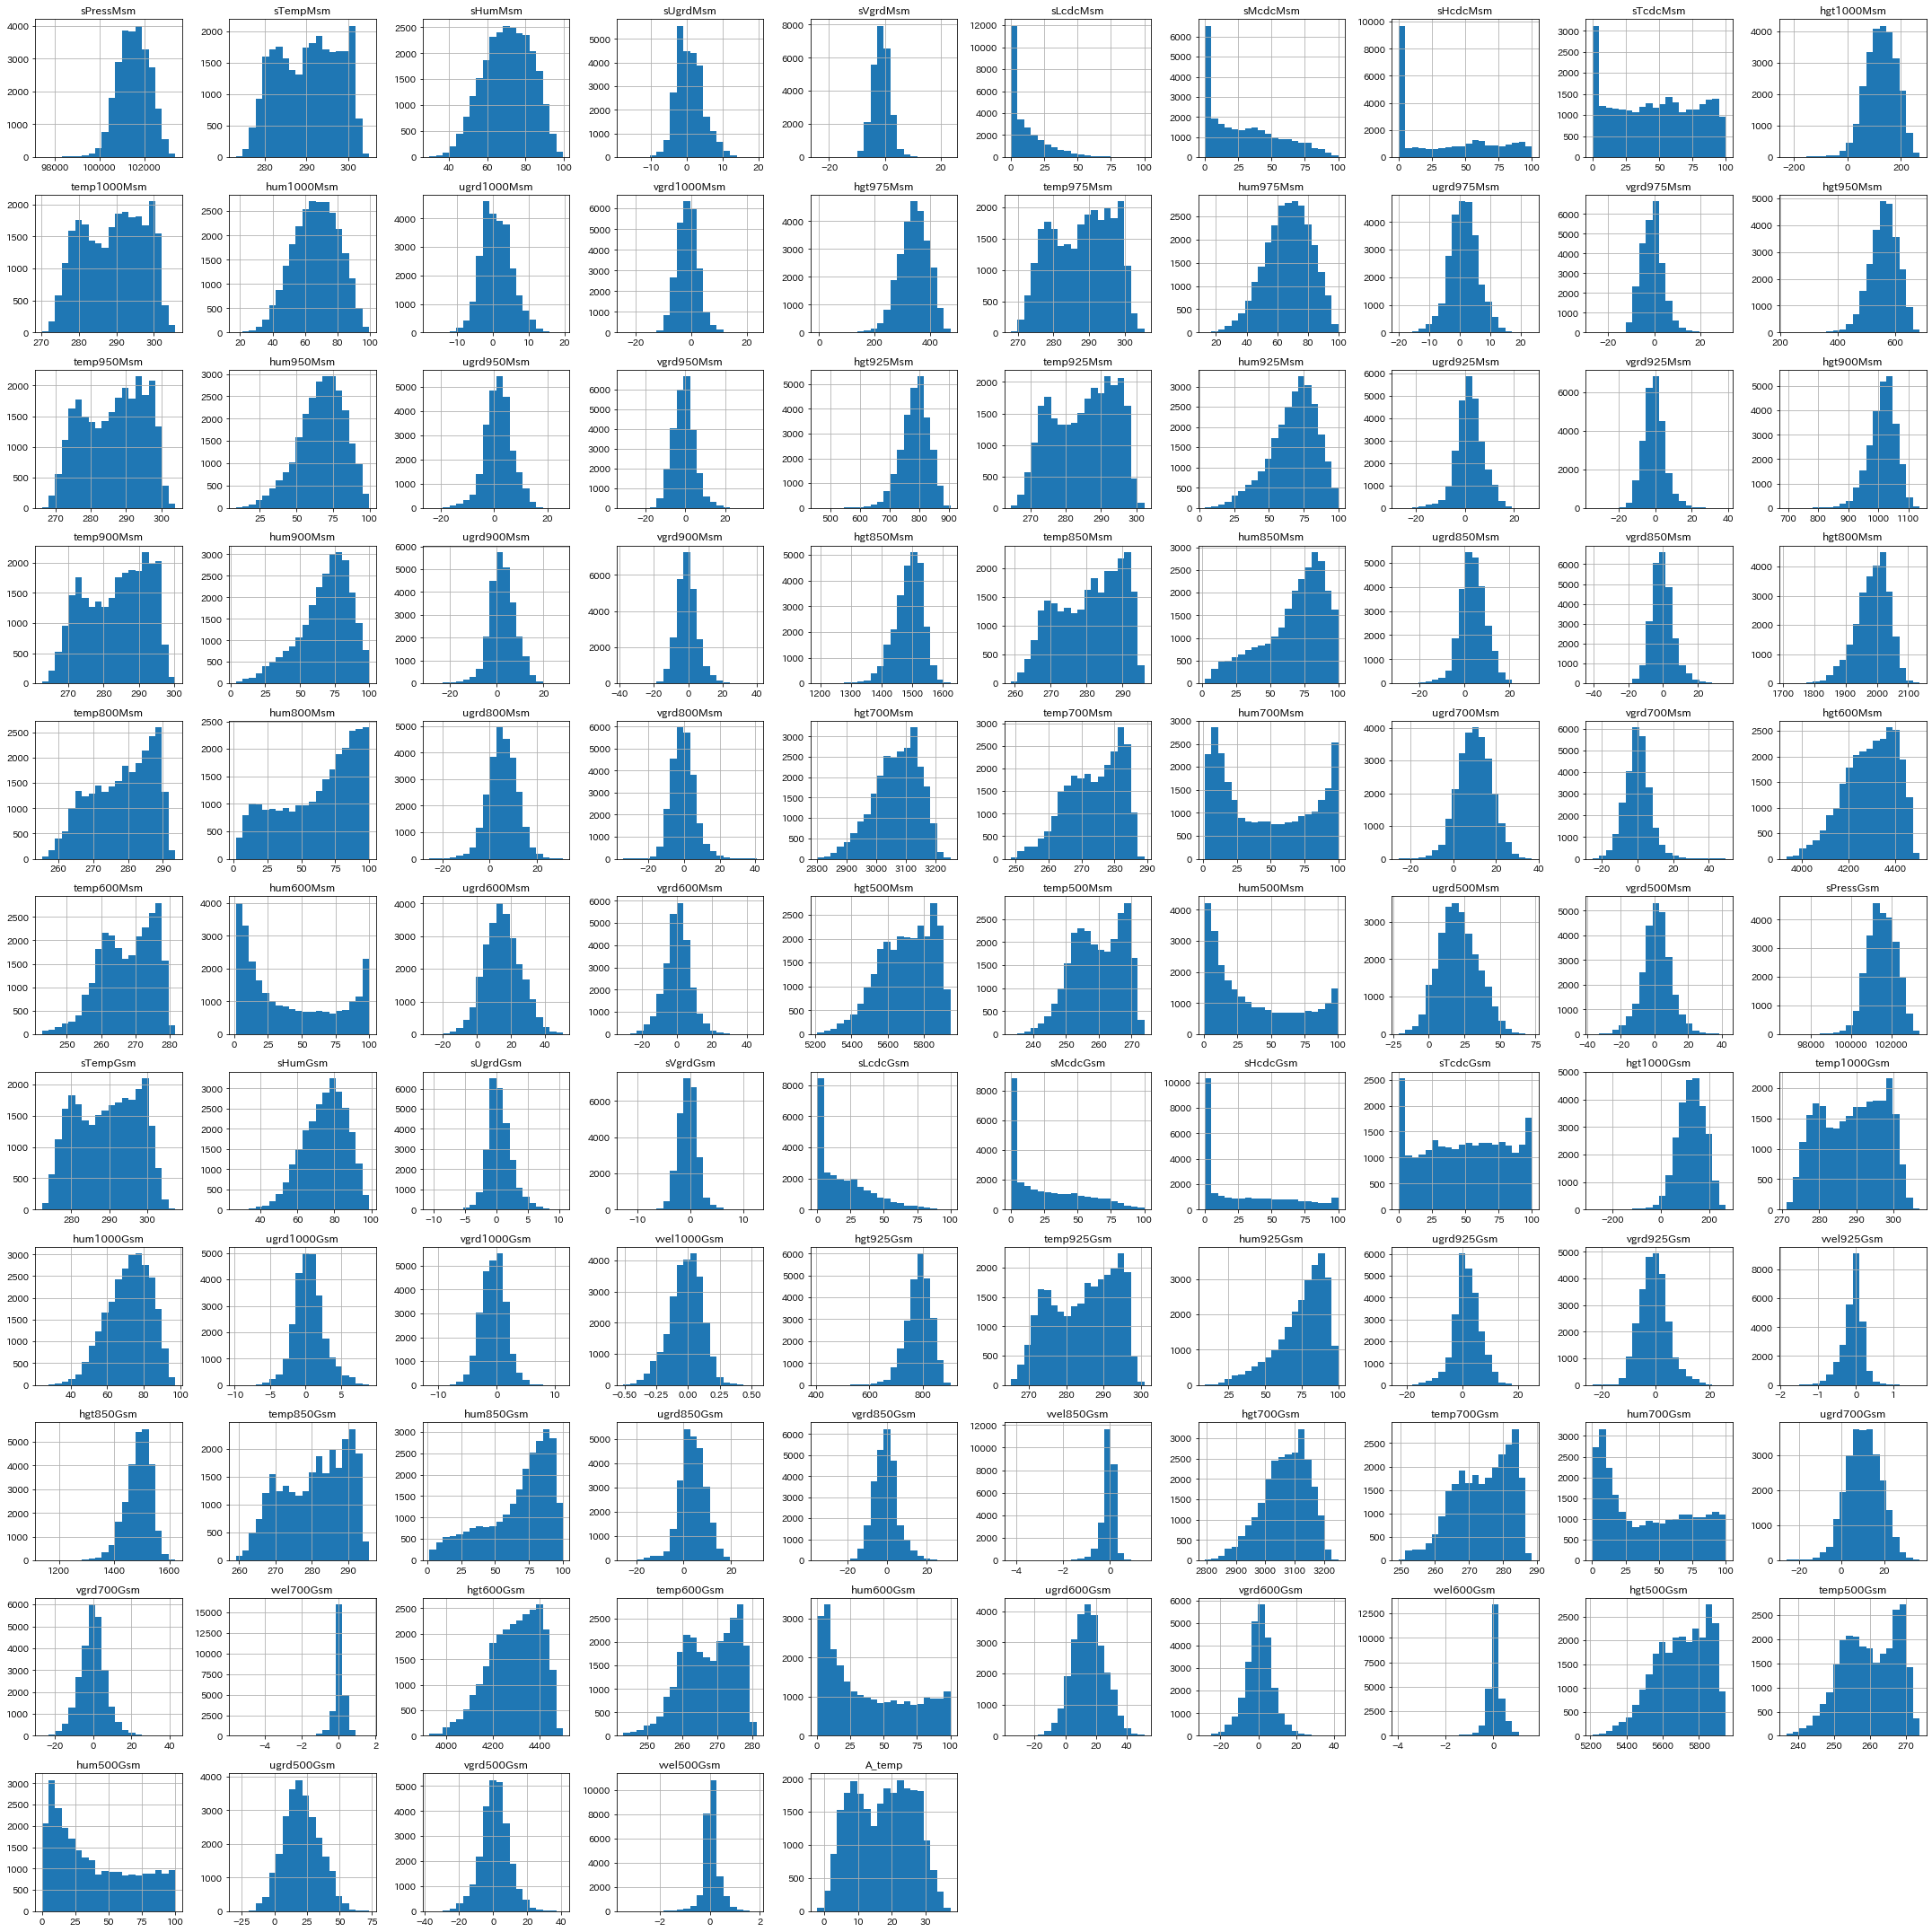

In [6]:
rcParams['figure.figsize'] = 30,30
data.hist(bins=20)
plt.tight_layout()
#plt.savefig('data_hist.png', dpi=200)
plt.show()

In [9]:
print(data.corr())

            sPressMsm  sTempMsm   sHumMsm  sUgrdMsm  sVgrdMsm  sLcdcMsm  \
sPressMsm    1.000000 -0.628835 -0.450127 -0.052605 -0.236901 -0.371289   
sTempMsm    -0.628835  1.000000  0.480400 -0.186657  0.349042  0.151774   
sHumMsm     -0.450127  0.480400  1.000000 -0.114182  0.269855  0.435327   
sUgrdMsm    -0.052605 -0.186657 -0.114182  1.000000  0.259020 -0.119177   
sVgrdMsm    -0.236901  0.349042  0.269855  0.259020  1.000000 -0.036469   
...               ...       ...       ...       ...       ...       ...   
hum500Gsm   -0.182090  0.187773  0.256522 -0.277118  0.123399  0.281673   
ugrd500Gsm   0.376202 -0.734964 -0.408720  0.407201 -0.204743 -0.038389   
vgrd500Gsm  -0.285171  0.228106  0.193440 -0.176188  0.114074  0.269334   
vvel500Gsm   0.275689 -0.313379 -0.275217  0.411713 -0.177563 -0.234126   
A_temp      -0.616531  0.973146  0.457029 -0.133652  0.368520  0.097997   

            sMcdcMsm  sHcdcMsm  sTcdcMsm  hgt1000Msm  temp1000Msm  hum1000Msm  \
sPressMsm  -0.2843

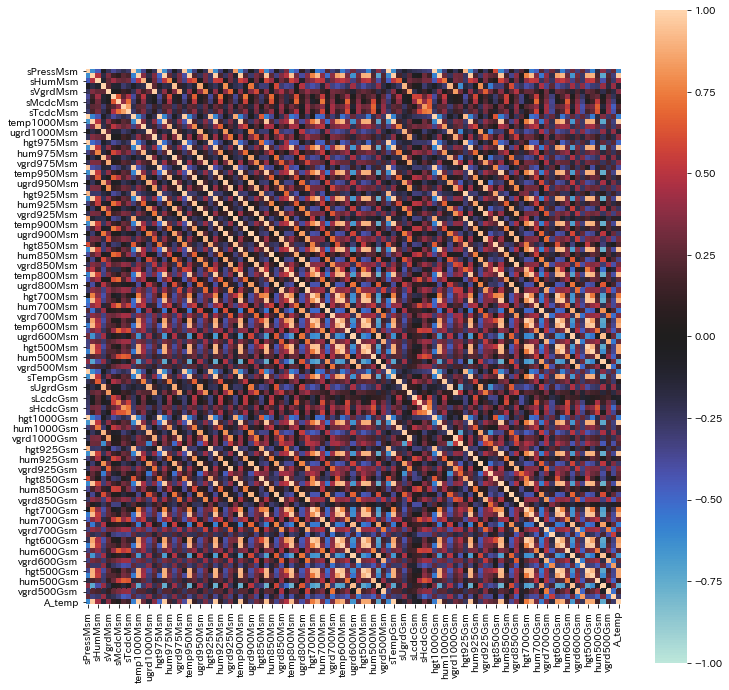

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.corr(), square=True, vmax=1, vmin=-1, center=0)
plt.show()

In [11]:
X_train = data.drop('A_temp', axis=1)
y_train = data['A_temp']

In [12]:
TEST_PASS = 'data/2020.csv'

df = load_csv(TEST_PASS)
print(df.shape)
df.head()

(8785, 105)


,sPressMsm,sTempMsm,sHumMsm,sUgrdMsm,sVgrdMsm,sLcdcMsm,sMcdcMsm,sHcdcMsm,sTcdcMsm,hgt1000Msm,temp1000Msm,hum1000Msm,ugrd1000Msm,vgrd1000Msm,hgt975Msm,temp975Msm,hum975Msm,ugrd975Msm,vgrd975Msm,hgt950Msm,temp950Msm,hum950Msm,ugrd950Msm,vgrd950Msm,hgt925Msm,temp925Msm,hum925Msm,ugrd925Msm,vgrd925Msm,hgt900Msm,temp900Msm,hum900Msm,ugrd900Msm,vgrd900Msm,hgt850Msm,temp850Msm,hum850Msm,ugrd850Msm,vgrd850Msm,hgt800Msm,temp800Msm,hum800Msm,ugrd800Msm,vgrd800Msm,hgt700Msm,temp700Msm,hum700Msm,ugrd700Msm,vgrd700Msm,hgt600Msm,temp600Msm,hum600Msm,ugrd600Msm,vgrd600Msm,hgt500Msm,temp500Msm,hum500Msm,ugrd500Msm,vgrd500Msm,sPressGsm,sTempGsm,sHumGsm,sUgrdGsm,sVgrdGsm,sLcdcGsm,sMcdcGsm,sHcdcGsm,sTcdcGsm,hgt1000Gsm,temp1000Gsm,hum1000Gsm,ugrd1000Gsm,vgrd1000Gsm,vvel1000Gsm,hgt925Gsm,temp925Gsm,hum925Gsm,ugrd925Gsm,vgrd925Gsm,vvel925Gsm,hgt850Gsm,temp850Gsm,hum850Gsm,ugrd850Gsm,vgrd850Gsm,vvel850Gsm,hgt700Gsm,temp700Gsm,hum700Gsm,ugrd700Gsm,vgrd700Gsm,vvel700Gsm,hgt600Gsm,temp600Gsm,hum600Gsm,ugrd600Gsm,vgrd600Gsm,vvel600Gsm,hgt500Gsm,temp500Gsm,hum500Gsm,ugrd500Gsm,vgrd500Gsm,vvel500Gsm,A_temp
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,102618.00,278.996,65.8416,2.142250,-5.533290,12.695300,7.177730,0.0,12.695300,210.05,275.997,63.1661,2.22340,-6.534490,414.12,273.932,66.3138,1.872730,-7.882230,622.00,272.032,67.5406,1.341060,-9.482070,833.96,270.189,71.1825,1.496660,-10.345700,1050.26,268.449,75.4742,2.624060,-10.706300,1497.82,266.487,61.8816,7.15211,-9.78978,1971.38,267.253,25.6807,9.125620,-8.332450,3017.04,265.270,5.2790,16.242100,-6.584810,4201.39,259.562,2.3639,23.596200,-3.467260,5563.35,250.656,2.0982,34.412900,-0.072857,102582.50,277.129,67.7963,0.814817,-2.969570,13.940448,13.647450,0.0,21.044898,206.29,275.571,65.0871,1.318210,-4.335515,-0.158814,829.86,269.947,78.8073,2.180130,-9.070365,-0.096140,1492.84,265.995,65.7277,6.244410,-10.517725,0.064540,3016.53,266.379,2.8849,15.798350,-6.175285,0.421736,4202.93,259.618,2.0368,24.18905,-3.130345,0.329991,5567.55,251.836,3.5076,36.524000,-0.154200,0.300375,5.1
2020-01-01 01:00:00,102616.33,279.009,66.0024,2.203987,-5.199180,11.425773,8.561187,0.0,12.239567,209.94,276.055,63.7039,2.25056,-6.097497,414.05,274.010,66.5098,1.754443,-7.346957,622.03,272.145,67.3612,1.135123,-8.833917,834.05,270.313,71.3316,1.377570,-9.620130,1050.46,268.591,75.8263,2.665037,-9.946783,1498.26,266.509,65.5091,7.39286,-9.03035,1971.98,267.382,25.3656,9.424680,-8.518093,3017.36,265.207,5.6929,16.143133,-6.502600,4201.73,259.515,2.2299,24.982567,-3.805123,5562.96,250.733,2.2518,35.465667,-0.953198,102592.33,276.923,68.7546,0.766616,-2.581493,9.407565,9.098300,0.0,14.143865,206.95,275.388,65.8332,1.272280,-3.873730,-0.136798,830.18,269.842,78.7868,2.091910,-8.568653,-0.068611,1493.42,266.414,59.2837,6.899163,-10.164300,0.075771,3017.17,266.115,3.4136,16.411033,-6.035927,0.392441,4202.68,259.414,2.3267,24.83330,-3.084733,0.325143,5565.95,251.575,4.2289,36.728733,-0.640453,0.314466,5.0
2020-01-01 02:00:00,102614.67,279.023,66.1632,2.265723,-4.865070,10.156247,9.944643,0.0,11.783833,209.83,276.113,64.2416,2.27772,-5.660503,413.99,274.087,66.7059,1.636157,-6.811683,622.05,272.258,67.1818,0.929186,-8.185763,834.13,270.436,71.4807,1.258480,-8.894560,1050.65,268.732,76.1784,2.706013,-9.187267,1498.71,266.531,69.1366,7.63361,-8.27092,1972.59,267.512,25.0504,9.723740,-8.703737,3017.67,265.143,6.1069,16.044167,-6.420390,4202.07,259.467,2.0959,26.368933,-4.142987,5562.56,250.811,2.4055,36.518433,-1.833539,102602.17,276.718,69.7130,0.718415,-2.193417,4.874681,4.549150,0.0,7.242831,207.60,275.205,66.5794,1.226350,-3.411945,-0.114783,830.49,269.737,78.7664,2.003690,-8.066942,-0.041083,1493.99,266.833,52.8397,7.553917,-9.810875,0.087002,3017.81,265.851,3.9424,17.023717,-5.896568,0.363145,4202.43,259.210,2.6165,25.47755,-3.039122,0.320295,5564.36,251.313,4.9501,36.933467,-1.126707,0.328557,4.8
2020-01-01 03:00:00,102613.00,279.036,66.3240,2.327

In [13]:
basename = os.path.splitext(os.path.basename(TEST_PASS))[0]
print(basename)

2020


In [14]:
X_test = df.drop('A_temp', axis=1)
y_test = df['A_temp']

In [15]:
X_train.head()

,sPressMsm,sTempMsm,sHumMsm,sUgrdMsm,sVgrdMsm,sLcdcMsm,sMcdcMsm,sHcdcMsm,sTcdcMsm,hgt1000Msm,temp1000Msm,hum1000Msm,ugrd1000Msm,vgrd1000Msm,hgt975Msm,temp975Msm,hum975Msm,ugrd975Msm,vgrd975Msm,hgt950Msm,temp950Msm,hum950Msm,ugrd950Msm,vgrd950Msm,hgt925Msm,temp925Msm,hum925Msm,ugrd925Msm,vgrd925Msm,hgt900Msm,temp900Msm,hum900Msm,ugrd900Msm,vgrd900Msm,hgt850Msm,temp850Msm,hum850Msm,ugrd850Msm,vgrd850Msm,hgt800Msm,temp800Msm,hum800Msm,ugrd800Msm,vgrd800Msm,hgt700Msm,temp700Msm,hum700Msm,ugrd700Msm,vgrd700Msm,hgt600Msm,temp600Msm,hum600Msm,ugrd600Msm,vgrd600Msm,hgt500Msm,temp500Msm,hum500Msm,ugrd500Msm,vgrd500Msm,sPressGsm,sTempGsm,sHumGsm,sUgrdGsm,sVgrdGsm,sLcdcGsm,sMcdcGsm,sHcdcGsm,sTcdcGsm,hgt1000Gsm,temp1000Gsm,hum1000Gsm,ugrd1000Gsm,vgrd1000Gsm,vvel1000Gsm,hgt925Gsm,temp925Gsm,hum925Gsm,ugrd925Gsm,vgrd925Gsm,vvel925Gsm,hgt850Gsm,temp850Gsm,hum850Gsm,ugrd850Gsm,vgrd850Gsm,vvel850Gsm,hgt700Gsm,temp700Gsm,hum700Gsm,ugrd700Gsm,vgrd700Gsm,vvel700Gsm,hgt600Gsm,temp600Gsm,hum600Gsm,ugrd600Gsm,vgrd600Gsm,vvel600Gsm,hgt500Gsm,temp500Gsm,hum500Gsm,ugrd500Gsm,vgrd500Gsm,vvel500Gsm
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 09:00:00,102796.00,283.207,59.4152,2.512950,-1.638670,2.246090,31.738300,0.0000,31.738300,227.89,280.579,60.0185,3.355850,-1.372590,435.57,278.683,59.5603,4.179160,-1.044150,647.25,277.000,53.0185,4.400010,-1.086780,863.17,275.363,51.8165,3.661070,-1.586080,1083.65,273.650,57.7108,2.762260,-2.701000,1539.23,270.011,88.0159,2.89410,-6.66722,2017.14,268.351,48.7764,8.109540,-8.91821,3062.13,266.335,5.8654,14.882100,-14.732200,4257.42,262.313,1.3772,24.354500,-17.7678,5634.39,254.183,5.4910,38.054800,-22.151600,102833.00,279.811,93.6797,0.641642,0.767023,57.128900,5.322270,0.0,57.128900,229.09,278.488,85.4047,1.717670,0.579786,0.083453,862.72,274.786,84.8704,3.28135,-3.97059,-0.023447,1538.52,270.590,72.6527,4.537880,-6.84858,0.442675,3064.54,266.624,7.4089,15.205700,-12.992800,0.705063,4259.40,262.298,2.2813,23.863400,-17.43970,0.555656,5637.20,254.288,5.9063,36.086600,-20.855200,0.336329
2017-01-01 10:00:00,102765.67,283.439,57.9528,2.928917,-1.327344,4.036457,23.600273,0.0000,23.714207,225.64,280.802,58.5770,3.521020,-1.175096,433.46,278.856,59.9649,4.017193,-0.974090,645.24,277.076,56.8311,4.036980,-1.007309,861.27,275.449,56.1568,3.247610,-1.345996,1081.82,273.740,62.9492,2.492317,-2.400120,1537.70,270.354,80.4229,3.25515,-6.14924,2016.70,269.158,39.7220,8.483713,-8.42445,3065.05,267.088,5.1055,15.350033,-13.157167,4261.66,262.458,2.4385,23.150667,-16.3193,5639.65,254.424,8.6515,36.631567,-20.021033,102792.67,280.443,89.4679,0.785278,0.550855,47.957352,4.435225,0.0,47.957352,226.30,279.079,82.2992,1.754073,0.367112,0.051626,860.70,274.980,84.7552,3.15793,-3.64174,-0.011605,1537.02,270.879,67.5135,4.979877,-6.61906,0.377764,3066.19,267.247,6.9034,15.272083,-12.535167,0.641778,4262.83,262.558,2.5677,23.717433,-16.42695,0.519735,5641.74,254.349,10.8126,35.227033,-19.271883,0.323268
2017-01-01 11:00:00,102735.33,283.670,56.4903,3.344883,-1.016017,5.826823,15.462247,0.0000,15.690113,223.38,281.026,57.1354,3.686190,-0.977603,431.34,279.030,60.3696,3.855227,-0.904030,643.23,277.153,60.6437,3.673950,-0.927837,859.36,275.535,60.4971,2.834150,-1.105912,1079.99,273.829,68.1875,2.222373,-2.099240,1536.16,270.698,72.8300,3.61620,-5.63126,2016.27,269.964,30.6676,8.857887,-7.93069,3067.98,267.840,4.3455,15.817967,-11.582133,4265.91,262.602,3.4997,21.946833,-14.8708,5644.90,254.664,11.8119,35.208333,-17.890467,102752.33,281.075,85.2561,0.928915,0.334686,38.785803,3.548180,0.0,38.785803,223.52,279.669,79.1938,1.790477,0.154437,0.019800,858.68,275.174,84.6400,3.03451,-3.31289,0.000236,1535.52,271.167,62.3744,5.421873,-6.38954,0.312853,3067.85,267.870,6.3980,15.338467,-12.077533,0.578493,4266.26,262.819,2.8542,23.571467,-15.41420,0.483815,5646.28,254.411,15.7188,34.367467,-17.688567,0.310207
2017-01-01 12:00:00,102705.00,283.902,55.0279,3.760850,-0.704691,7.6

In [194]:
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
#from WindowedTestTimeSeriesSplit import WindowedTestTimeSeriesSplit

params = {
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse'],
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'max_depth': 6, # default -1 means no limit
    'min_child_weight': 3, # default 20
    'subsample': 0.7, # 特徴量サンプリングの割合（何％の特徴量を利用するか）
    'colsample_bytree': 0.8, # バギングの割合（トレーニングデータの何％を利用するか）
    'gamma': 0.4,
    'alpha': 0, #1e-04,
    'lambda': 1, #1e-04,
    'random_state': 42
   }

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
list_rmse = []

kf = KFold(n_splits=4, shuffle=False)
kf_shuffle = KFold(n_splits=4, shuffle=True, random_state=71)
model_num = 0

for tr_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[tr_index], y_train.iloc[val_index]
    xgb_train = xgb.DMatrix(X_tr, label=y_tr, feature_names=X_tr.columns)
    xgb_eval = xgb.DMatrix(X_val, label=y_val, feature_names=X_val.columns)
    watchlist = [(xgb_train, 'train'), (xgb_eval, 'eval')]
    evals_result = {}
    
    model = xgb.train(
        params, xgb_train,
        num_boost_round=10000,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=100,
        early_stopping_rounds=20
    )

    y_tr_pred = model.predict(xgb_train, ntree_limit=model.best_ntree_limit)
    oof_train[val_index] = model.predict(xgb_eval, ntree_limit=model.best_ntree_limit)
    data = xgb.DMatrix(X_test)
    y_pred = model.predict(data, ntree_limit=model.best_ntree_limit)
    
    # 各モデルの学習データ、バリデーションデータ、テストデータにおけるRMSEの算出
    df_rmse_cv = pd.DataFrame({'学習RMSE': [np.sqrt(mean_squared_error(y_tr, y_tr_pred))],
                               '検証RMSE': [np.sqrt(mean_squared_error(y_val, oof_train[val_index]))],
                               'テストRMSE': [np.sqrt(mean_squared_error(y_test, y_pred))]},
                             index=[model_num])
    df_rmse_cv.index.name = 'モデル番号'

    list_rmse.append(df_rmse_cv)
    df_rmse = pd.concat(list_rmse, axis=0)

    y_preds.append(y_pred)
    models.append(model)
    
    model_num += 1

[0]	train-rmse:16.68279	eval-rmse:18.46274
[100]	train-rmse:0.64176	eval-rmse:1.18112
[200]	train-rmse:0.49633	eval-rmse:1.16989
[232]	train-rmse:0.46080	eval-rmse:1.16727
[0]	train-rmse:18.16647	eval-rmse:13.55161
[100]	train-rmse:0.63438	eval-rmse:1.16562
[200]	train-rmse:0.48269	eval-rmse:1.15406
[261]	train-rmse:0.41917	eval-rmse:1.15128
[0]	train-rmse:17.32818	eval-rmse:16.53601
[100]	train-rmse:0.65317	eval-rmse:1.04833
[159]	train-rmse:0.55471	eval-rmse:1.04320
[0]	train-rmse:16.30170	eval-rmse:19.41267
[100]	train-rmse:0.64085	eval-rmse:1.10667
[118]	train-rmse:0.60964	eval-rmse:1.10694


In [195]:
preds_average = np.mean(np.array(y_preds), axis=0)
print(preds_average.shape)

(8785,)


for model in models:
    _, ax = plt.subplots(figsize=(32,24))
    xgb.plot_importance(model,
                        ax=ax,
                        importance_type='gain',
                        show_values=True)
    plt.show()

In [196]:
CSV_SAVE_PASS = 'result_csv/' + str(basename)
os.makedirs(CSV_SAVE_PASS, exist_ok=True)

In [197]:
pred_filename = os.path.join(CSV_SAVE_PASS, 'predicted_temp_' + str(basename) + '_by_XGB.csv')

index = df.index
pred_df = pd.Series(preds_average, index=index, name='predicted_temp')
pred_df.to_csv(pred_filename)

In [198]:
rmse_filename = os.path.join(CSV_SAVE_PASS, 'rmse_' + str(basename) + '_by_XGB.csv')
df_rmse = df_rmse.round(2)
df_rmse.head()
df_rmse.to_csv(rmse_filename, encoding='sjis')

In [199]:
average_rmse = pd.Series(np.sqrt(mean_squared_error(y_test, preds_average)))
average_rmse.index.name = '最終予測値RMSE'
average_rmse.head()

最終予測値RMSE
0    1.193101
dtype: float64

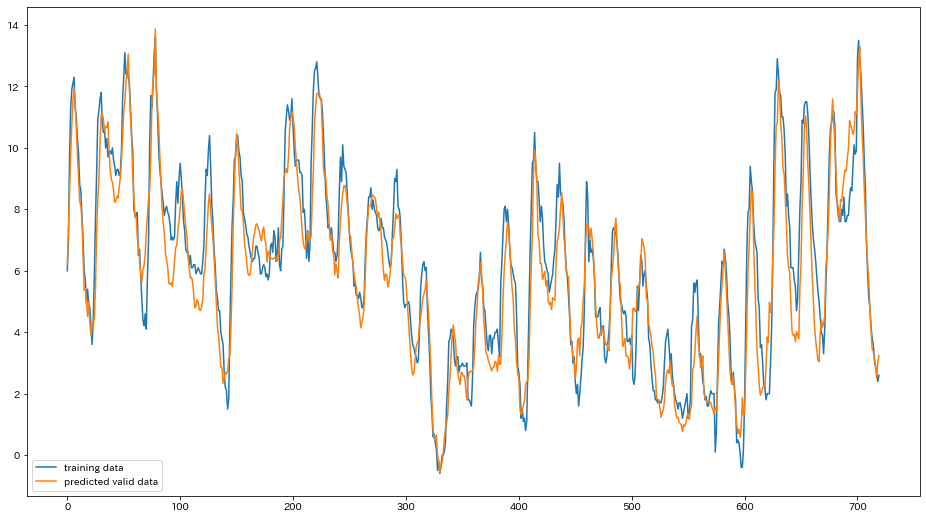

In [182]:
fig = plt.figure(figsize=(16,9))
start = 0
stop = start + 720
plt.plot(y_train.values[start:stop], label='training data')
plt.plot(oof_train[start:stop], label='predicted valid data')
plt.legend()

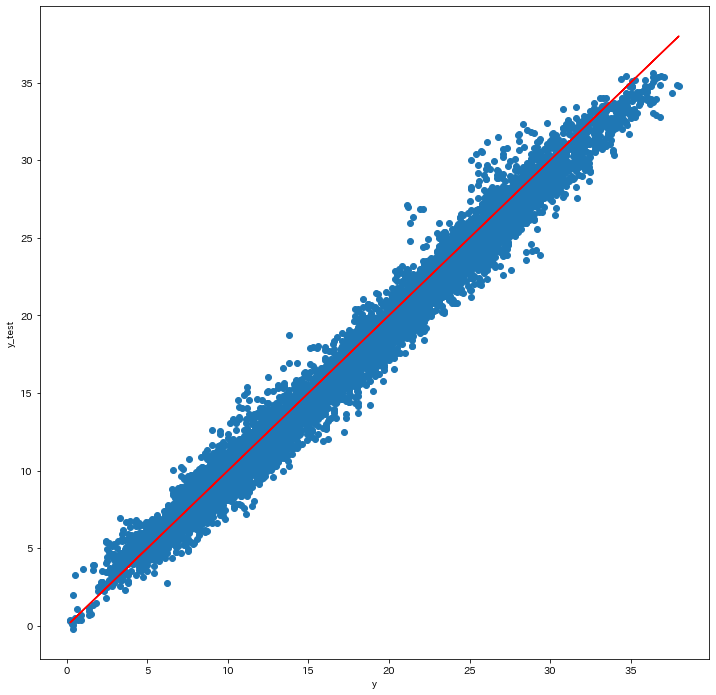

In [183]:
plt.figure(figsize=(12,12))
start = 0
stop = start + len(y_test)
plt.plot(y_test[start:stop], y_test[start:stop], c='r', label='X=y')
plt.scatter(y_test[start:stop], preds_average[start:stop])
plt.xlabel('y')
plt.ylabel('y_test')
#plt.title('n_splits='+str(n_fold))
#plt.savefig('n_splits_'+str(n_fold)+'.png')
plt.show()

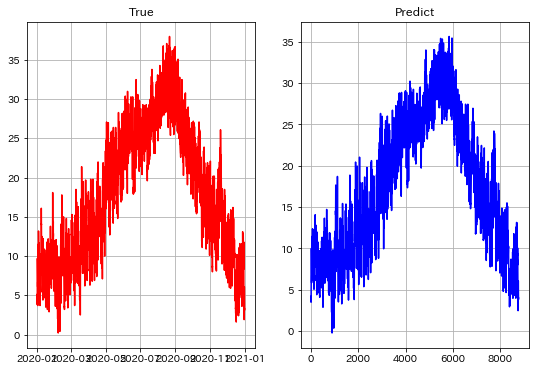

In [184]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,6)) 

ax1.plot(y_test, color='red')
ax1.set_title('True')
#ax1.set_ylim(100, 600)
ax1.grid(True)

ax2.plot(preds_average, color='blue')
ax2.set_title('Predict')
#ax2.set_ylim(100,600)
ax2.grid(True)

In [185]:
SAVE_PASS = 'result_img/' + str(basename)
os.makedirs(SAVE_PASS, exist_ok=True)
filename = os.path.join(SAVE_PASS, 'pred_' + str(basename) + '.png')
print(filename)

result_img/2020\pred_2020.png


In [186]:
from matplotlib.dates import date2num, DateFormatter

C:\Users\mec\anaconda3\envs\works\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


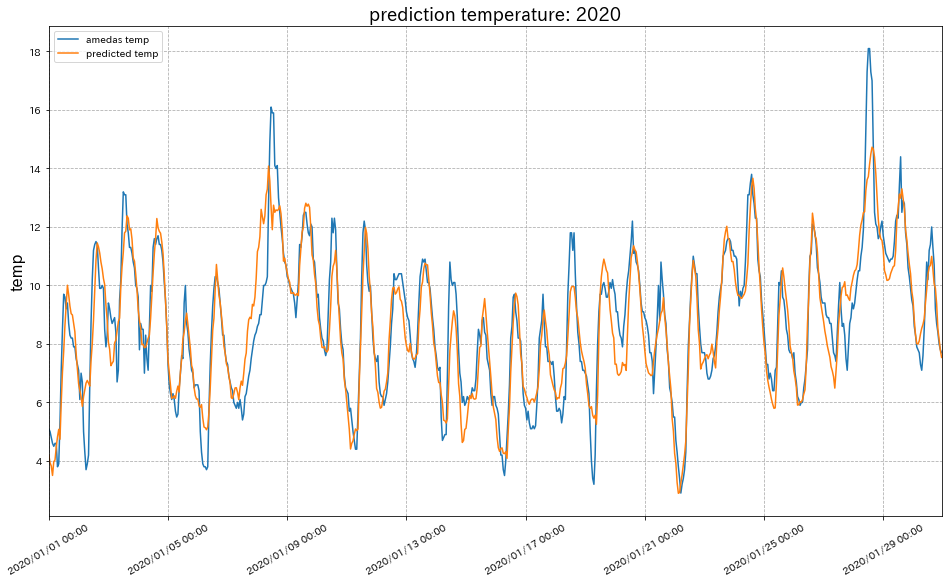

In [187]:
fig = plt.figure(figsize=(16,9))
start = 0
stop = start + 720

pred_s = pd.Series(preds_average, index=y_test.index)

plt.title('prediction temperature: ' + str(basename), fontsize=18)
ax = fig.add_subplot(1,1,1)
ax.plot(y_test[start:stop], label='amedas temp')
ax.plot(pred_s[start:stop], label='predicted temp')
ax.set_xlim(date2num([df[start:stop].index.min(),
                     df[start:stop].index.max()]))
ax.xaxis.set_major_formatter(DateFormatter('%Y/%m/%d %H:%M'))
ax.set_ylabel('temp', fontsize=16)
#ax.set_xlabel('timesteps (m)', fontsize=16)
plt.xticks(rotation=30)
ax.legend()
ax.grid(linestyle='--')
#plt.savefig(filename, dpi=200)